# Computer Vision
## Exercise Sheet 3: Image Center, Edges, Keypoints
### Erhardt Barth / Christoph Linse / Manuel Laufer / Kathleen Anderson
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{erhardt.barth, c.linse, m.laufer, k.anderson} @uni-luebeck.de*

## Note: Please insert the names of all participating students:

1.
2.
3.
4.
5.


In [1]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

Cloning into 'cs4250'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 94 (delta 41), reused 68 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (94/94), 1.26 MiB | 7.16 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation

%matplotlib inline

## Exercise 3.1
### Finding the Image Center
Camera calibration refers to the process of computing the intrinsic and extrinsic parameters of the camera. It is a necessary step in many computer vision applications such as 3D scene reconstruction and recognition. One important intrinsic parameter is the image center. Print out the images `ueb311.jpg` and `ueb312.jpg` and estimate the image centers by using a ruler.

**Hint**: Make small printouts of the images to have enough space around them.

In [3]:
def load_image_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [4]:
def load_image_gray_normalized(image_path):
    return load_image_gray(image_path).astype('float32')/255.

In [5]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y


Estimated image center: [690.92584053 464.75139174]


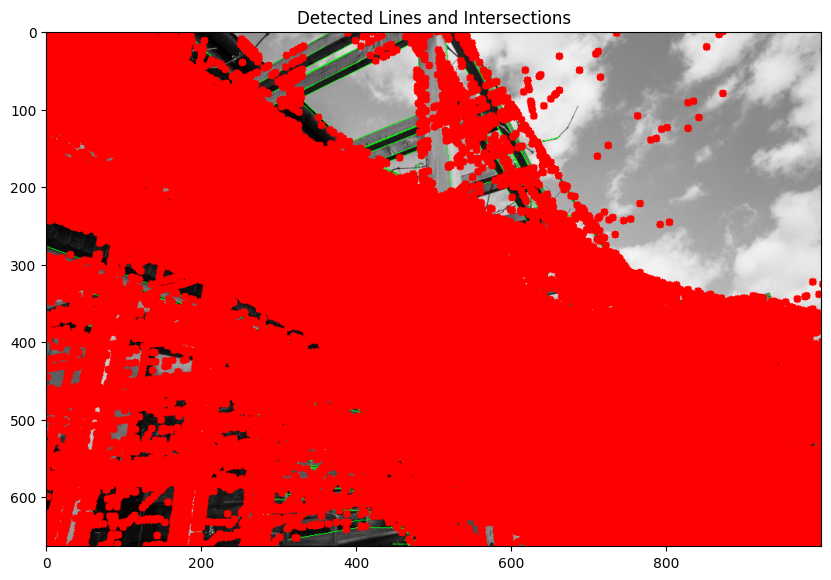

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def load_image_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

def detect_edges(image):
    return cv2.Canny(image, 100, 200)

def detect_lines(edge_image):
    lines = cv2.HoughLinesP(edge_image, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    return lines

def draw_lines(image, lines):
    line_img = image.copy()
    if len(image.shape) == 2:
        line_img = cv2.cvtColor(line_img, cv2.COLOR_GRAY2BGR)

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 1)
    return line_img

def find_intersections(lines):
    def compute_intersection(l1, l2):
        x1, y1, x2, y2 = l1
        x3, y3, x4, y4 = l2

        A1 = y2 - y1
        B1 = x1 - x2
        C1 = A1 * x1 + B1 * y1

        A2 = y4 - y3
        B2 = x3 - x4
        C2 = A2 * x3 + B2 * y3

        det = A1 * B2 - A2 * B1
        if det == 0:
            return None  # parallel lines
        else:
            x = (B2 * C1 - B1 * C2) / det
            y = (A1 * C2 - A2 * C1) / det
            return [int(x), int(y)]

    intersections = []
    if lines is not None:
        for (l1, l2) in combinations(lines[:, 0], 2):
            pt = compute_intersection(l1, l2)
            if pt is not None and 0 <= pt[0] <= 2000 and 0 <= pt[1] <= 2000:
                intersections.append(pt)
    return intersections

def plot_with_intersections(image, lines, intersections):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    line_image = draw_lines(image_rgb, lines)

    for pt in intersections:
        cv2.circle(line_image, tuple(pt), 5, (255, 0, 0), -1)

    plt.figure(figsize=(10, 8))
    plt.imshow(line_image)
    plt.title('Detected Lines and Intersections')
    plt.axis('on')
    plt.show()

def estimate_image_center(image_path):
    gray = load_image_gray(image_path)
    edges = detect_edges(gray)
    lines = detect_lines(edges)
    intersections = find_intersections(lines)

    if intersections:
        center_estimate = np.mean(intersections, axis=0)
        print(f"Estimated image center: {center_estimate}")
    else:
        print("No intersections found to estimate center.")

    plot_with_intersections(gray, lines, intersections)

# Run on your image
estimate_image_center('/content/cs4250/data/exercise_3/ueb312.jpg')


Estimated Image Center (vanishing point): [352.06133279 353.46306343]


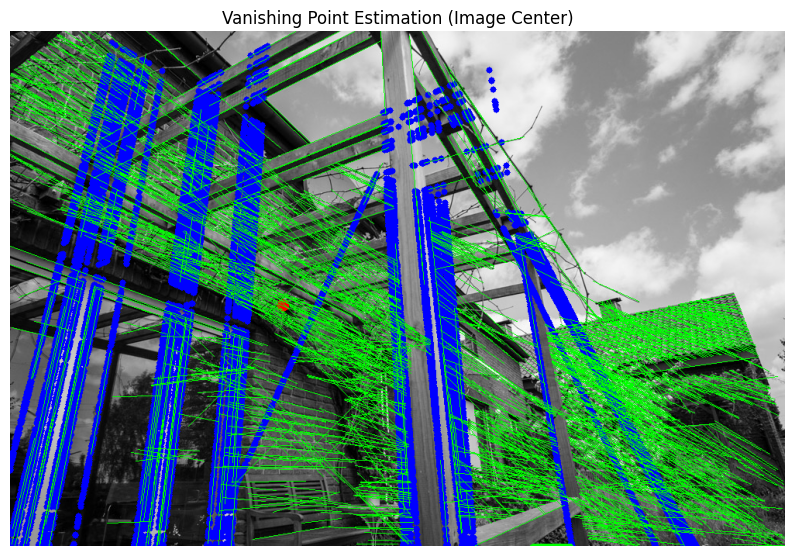

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import DBSCAN

def load_image_gray(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def detect_edges(image):
    return cv2.Canny(image, 100, 200)

def detect_lines(edge_image):
    lines = cv2.HoughLinesP(edge_image, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    return lines

def compute_angle(line):
    x1, y1, x2, y2 = line
    return np.arctan2((y2 - y1), (x2 - x1))

def group_lines_by_orientation(lines, angle_thresh=np.pi/6):
    verticals, horizontals = [], []
    for line in lines:
        angle = compute_angle(line[0])
        if abs(np.cos(angle)) < 0.5:  # Near-vertical
            verticals.append(line)
        elif abs(np.sin(angle)) < 0.5:  # Near-horizontal
            horizontals.append(line)
    return verticals, horizontals

def compute_intersection(l1, l2):
    x1, y1, x2, y2 = l1
    x3, y3, x4, y4 = l2

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    det = A1 * B2 - A2 * B1
    if abs(det) < 1e-10:
        return None  # Parallel lines
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    return [int(x), int(y)]

def find_intersections(lines_a, lines_b):
    intersections = []
    for la in lines_a:
        for lb in lines_b:
            pt = compute_intersection(la[0], lb[0])
            if pt is not None and all(0 <= x <= 3000 for x in pt):
                intersections.append(pt)
    return intersections

def cluster_intersections(intersections):
    if not intersections:
        return None, []

    pts = np.array(intersections)
    clustering = DBSCAN(eps=50, min_samples=3).fit(pts)
    labels = clustering.labels_

    # Find the largest cluster (not noise, i.e., label != -1)
    unique, counts = np.unique(labels[labels != -1], return_counts=True)
    if len(counts) == 0:
        return None, []

    main_cluster_label = unique[np.argmax(counts)]
    main_cluster_pts = pts[labels == main_cluster_label]
    center = np.mean(main_cluster_pts, axis=0)
    return center, main_cluster_pts

def draw_results(image, lines, center, intersections):
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for pt in intersections:
        cv2.circle(image_color, tuple(pt), 4, (255, 0, 0), -1)

    if center is not None:
        cv2.circle(image_color, tuple(center.astype(int)), 8, (0, 0, 255), -1)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_color, (x1, y1), (x2, y2), (0, 255, 0), 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title("Vanishing Point Estimation (Image Center)")
    plt.axis('off')
    plt.show()

def estimate_image_center(image_path):
    image = load_image_gray(image_path)
    edges = detect_edges(image)
    lines = detect_lines(edges)

    if lines is None:
        print("No lines detected.")
        return

    verticals, horizontals = group_lines_by_orientation(lines)

    intersections = find_intersections(verticals, horizontals)
    center, cluster_pts = cluster_intersections(intersections)

    if center is not None:
        print(f"Estimated Image Center (vanishing point): {center}")
    else:
        print("Could not reliably estimate image center.")

    draw_results(image, lines, center, cluster_pts)

# Run on one of your images
estimate_image_center('/content/cs4250/data/exercise_3/ueb312.jpg')


Estimated Image Center (vanishing point): [793.83237624 340.84484341]


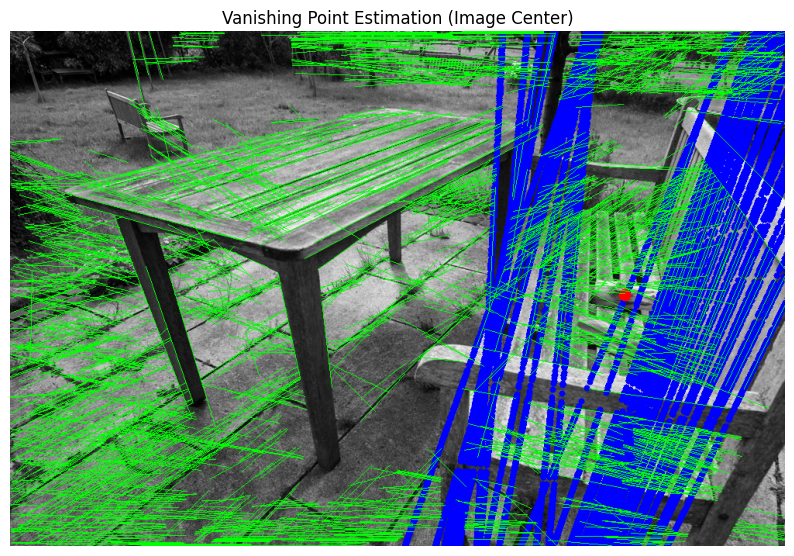

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn.cluster import DBSCAN

def load_image_gray(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def detect_edges(image):
    return cv2.Canny(image, 100, 200)

def detect_lines(edge_image):
    lines = cv2.HoughLinesP(edge_image, 1, np.pi / 180, threshold=100, minLineLength=50, maxLineGap=10)
    return lines

def compute_angle(line):
    x1, y1, x2, y2 = line
    return np.arctan2((y2 - y1), (x2 - x1))

def group_lines_by_orientation(lines, angle_thresh=np.pi/6):
    verticals, horizontals = [], []
    for line in lines:
        angle = compute_angle(line[0])
        if abs(np.cos(angle)) < 0.5:  # Near-vertical
            verticals.append(line)
        elif abs(np.sin(angle)) < 0.5:  # Near-horizontal
            horizontals.append(line)
    return verticals, horizontals

def compute_intersection(l1, l2):
    x1, y1, x2, y2 = l1
    x3, y3, x4, y4 = l2

    A1 = y2 - y1
    B1 = x1 - x2
    C1 = A1 * x1 + B1 * y1

    A2 = y4 - y3
    B2 = x3 - x4
    C2 = A2 * x3 + B2 * y3

    det = A1 * B2 - A2 * B1
    if abs(det) < 1e-10:
        return None  # Parallel lines
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det
    return [int(x), int(y)]

def find_intersections(lines_a, lines_b):
    intersections = []
    for la in lines_a:
        for lb in lines_b:
            pt = compute_intersection(la[0], lb[0])
            if pt is not None and all(0 <= x <= 3000 for x in pt):
                intersections.append(pt)
    return intersections

def cluster_intersections(intersections):
    if not intersections:
        return None, []

    pts = np.array(intersections)
    clustering = DBSCAN(eps=50, min_samples=3).fit(pts)
    labels = clustering.labels_

    # Find the largest cluster (not noise, i.e., label != -1)
    unique, counts = np.unique(labels[labels != -1], return_counts=True)
    if len(counts) == 0:
        return None, []

    main_cluster_label = unique[np.argmax(counts)]
    main_cluster_pts = pts[labels == main_cluster_label]
    center = np.mean(main_cluster_pts, axis=0)
    return center, main_cluster_pts

def draw_results(image, lines, center, intersections):
    image_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    for pt in intersections:
        cv2.circle(image_color, tuple(pt), 4, (255, 0, 0), -1)

    if center is not None:
        cv2.circle(image_color, tuple(center.astype(int)), 8, (0, 0, 255), -1)

    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_color, (x1, y1), (x2, y2), (0, 255, 0), 1)

    plt.figure(figsize=(10, 8))
    plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
    plt.title("Vanishing Point Estimation (Image Center)")
    plt.axis('off')
    plt.show()

def estimate_image_center(image_path):
    image = load_image_gray(image_path)
    edges = detect_edges(image)
    lines = detect_lines(edges)

    if lines is None:
        print("No lines detected.")
        return

    verticals, horizontals = group_lines_by_orientation(lines)

    intersections = find_intersections(verticals, horizontals)
    center, cluster_pts = cluster_intersections(intersections)

    if center is not None:
        print(f"Estimated Image Center (vanishing point): {center}")
    else:
        print("Could not reliably estimate image center.")

    draw_results(image, lines, center, cluster_pts)

# Run on one of your images
estimate_image_center('/content/cs4250/data/exercise_3/ueb311.jpg')


## Exercise 3.2.1
### Edge Detection
Open the image `ueb32.jpg` in Python and show the image gradients $d_x$ and $d_y$. Compute the magnitude of gradients image and apply a threshold to retain only the edges of the object. For those edges, compute and show the gradient angle image (`np.arctan2`). How can you tell the angle of the gradient from looking only at the gradients?

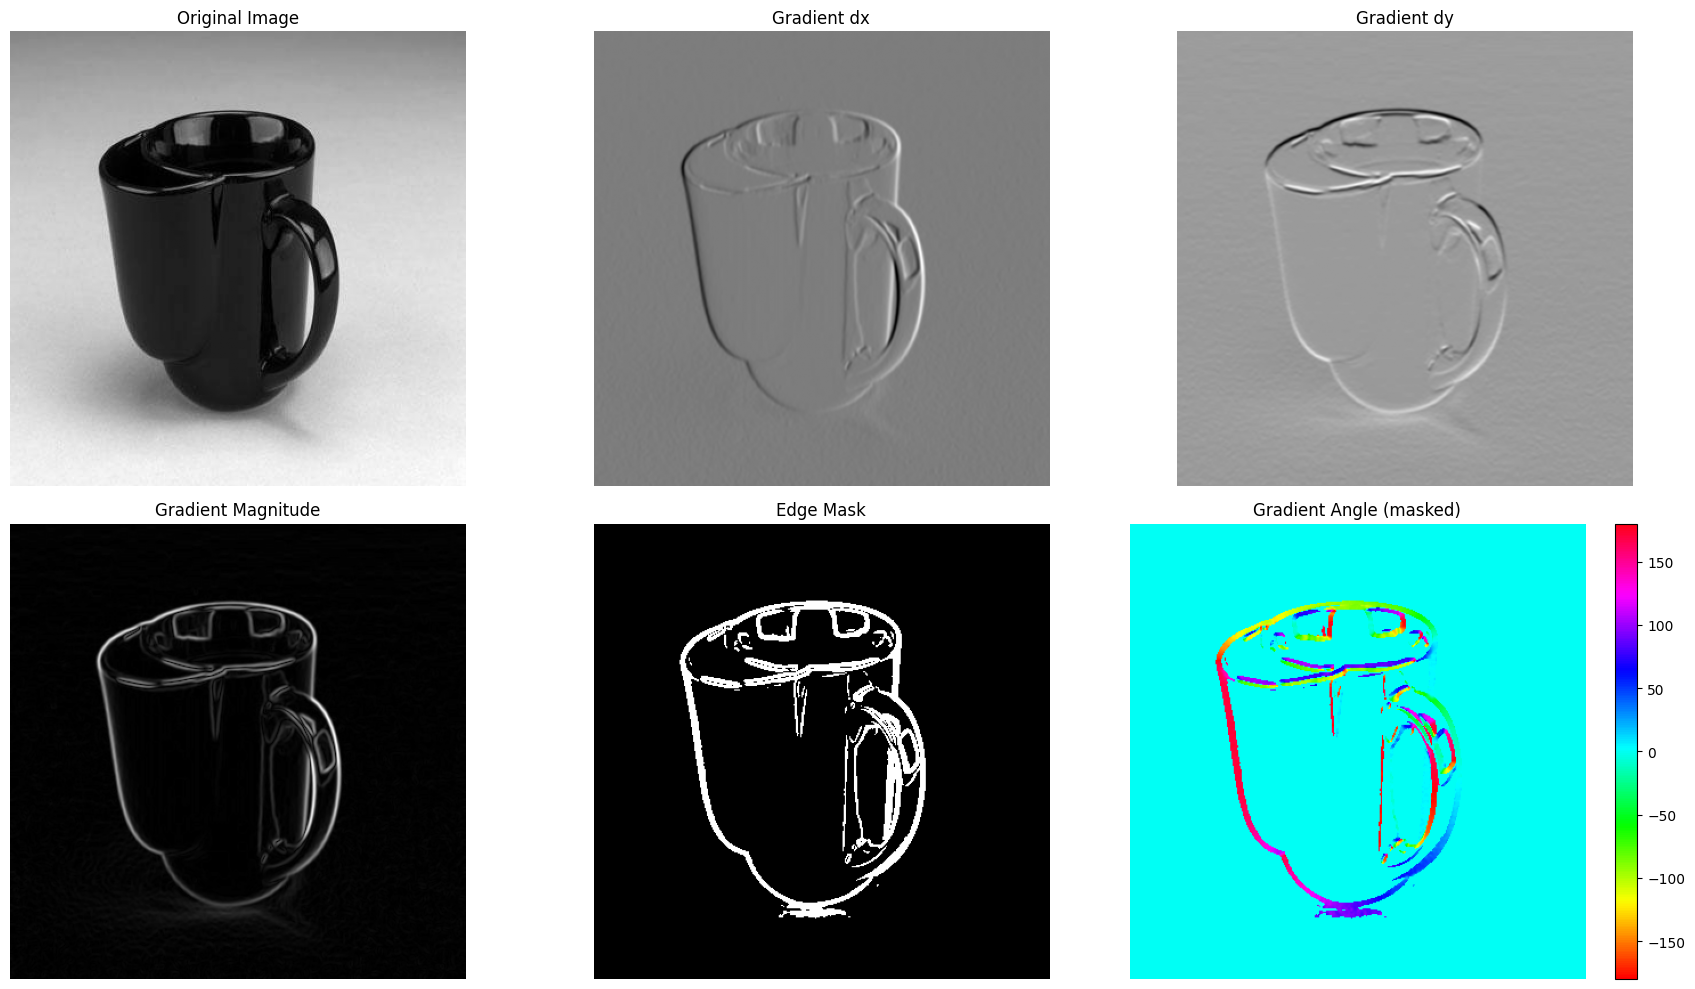

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# === 1. Load and smooth image ===
image = cv2.imread('/content/cs4250/data/exercise_3/ueb32.jpg', cv2.IMREAD_GRAYSCALE)
smoothed = cv2.GaussianBlur(image, (5, 5), sigmaX=1)

# === 2. Compute gradients (dx, dy) using Sobel ===
dx = cv2.Sobel(smoothed, cv2.CV_32F, 1, 0, ksize=3)
dy = cv2.Sobel(smoothed, cv2.CV_32F, 0, 1, ksize=3)

# Normalize for display
dx_disp = cv2.normalize(dx, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
dy_disp = cv2.normalize(dy, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# === 3. Compute gradient magnitude and angle ===
magnitude = np.sqrt(dx**2 + dy**2)
angle = np.arctan2(dy, dx) * (180 / np.pi)  # Convert to degrees in [-180, +180]

# === 4. Threshold magnitude to get strong edges ===
edge_mask = magnitude > 50  # Threshold (you can tune this)

# Mask angle image: only keep angles at edge positions
angle_masked = np.zeros_like(angle)
angle_masked[edge_mask] = angle[edge_mask]

# === 5. Display all results ===
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title("Original Image")

ax[0, 1].imshow(dx_disp, cmap='gray')
ax[0, 1].set_title("Gradient dx")

ax[0, 2].imshow(dy_disp, cmap='gray')
ax[0, 2].set_title("Gradient dy")

ax[1, 0].imshow(magnitude, cmap='gray')
ax[1, 0].set_title("Gradient Magnitude")

ax[1, 1].imshow(edge_mask, cmap='gray')
ax[1, 1].set_title("Edge Mask")

im = ax[1, 2].imshow(angle_masked, cmap='hsv', vmin=-180, vmax=180)
ax[1, 2].set_title("Gradient Angle (masked)")
plt.colorbar(im, ax=ax[1, 2])

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
plt.show()



## Exercise 3.2.2
### Canny Edge Detector
Open the image `ueb32.jpg` in Python and use the OpenCV Canny algorithm to find the edges in the image.
Compare the result with the magnitude of gradient image. Display both results side by side using `plt.subplots`.
Comment on how the two results differ and why.**Furthermore, comment how the angle image and the magnitude image are used in the Canny algorithm.**

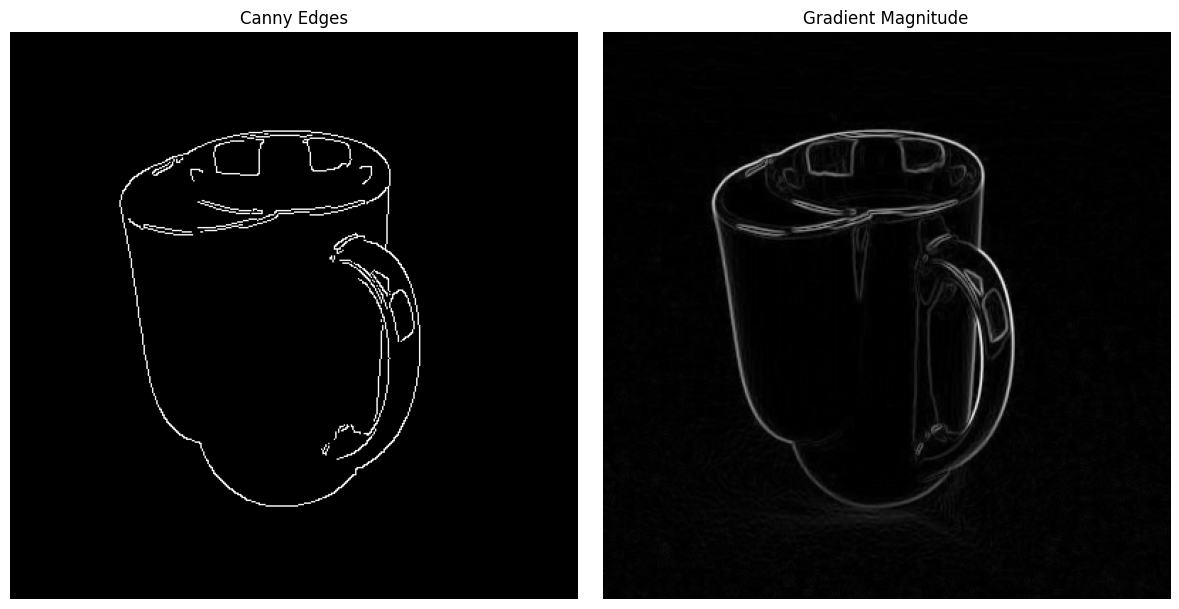

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('/content/cs4250/data/exercise_3/ueb32.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Canny Edge Detector
canny_edges = cv2.Canny(image, 100, 200)

# Compute gradients using Sobel
sobel_x = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)

# Gradient magnitude and angle
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
angle = np.arctan2(sobel_y, sobel_x)

# Normalize magnitude for visualization
magnitude_display = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
magnitude_display = magnitude_display.astype(np.uint8)

# Plot both side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(canny_edges, cmap='gray')
axes[0].set_title("Canny Edges")
axes[0].axis('off')

axes[1].imshow(magnitude_display, cmap='gray')
axes[1].set_title("Gradient Magnitude")
axes[1].axis('off')

plt.tight_layout()
plt.show()


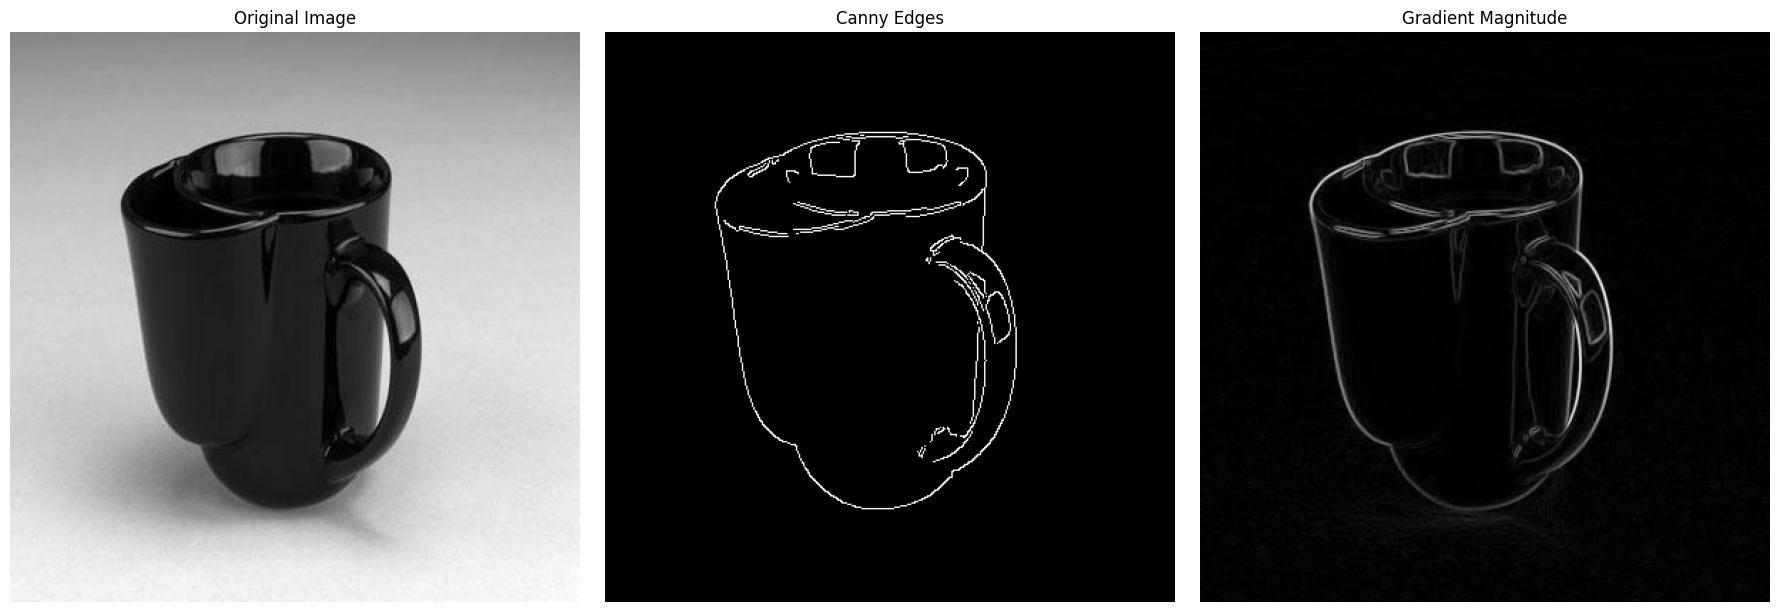

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image in grayscale
image = cv2.imread('/content/cs4250/data/exercise_3/ueb32.jpg', cv2.IMREAD_GRAYSCALE)

# Apply Canny Edge Detector
canny_edges = cv2.Canny(image, 100, 200)

# Compute gradients using Sobel
sobel_x = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(image.astype(np.float32), cv2.CV_64F, 0, 1, ksize=3)

# Gradient magnitude and angle
magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
angle = np.arctan2(sobel_y, sobel_x)

# Normalize magnitude for display
magnitude_display = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Display all 3 images side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(canny_edges, cmap='gray')
axes[1].set_title("Canny Edges")
axes[1].axis('off')

axes[2].imshow(magnitude_display, cmap='gray')
axes[2].set_title("Gradient Magnitude")
axes[2].axis('off')

plt.tight_layout()
plt.show()


## Exercise 3.3
### Key Point Detection
Implement the following key-point detectors:
* local maxima of $K$
* local maxima of $K$ − $\alpha$ $H^2$, with $\alpha$ as weighting parameter

The function is supposed to return images of the same size as the input, where the pixels contain $K$ or $K$ − $\alpha$ $H^2$.

$K$ and $H$ should be the invariants of the structure tensor $J$ (see script).
Evaluate the detectors above on two kinds of test images: (i) the synthetic image `ueb331.npy`, (ii) the
picture `ueb332.jpg`.

Comment your results with a focus on
1. the localization of the key points
2. the influence of the $H$ term as controlled via the parameter $\alpha$.

**Question**: Why do you filter the image with a Gaussian kernel a second time? It is **not** about noise removal!

**Hint**: Use the provided functions `find_local_max` and `plot_marks`.

In [ ]:
def find_local_max(keypoints, thres=1e-6, k=3):
    kernel = np.ones((k, k))
    kernel[k//2, k//2] = 0
    local_max = keypoints > thres + dilation(keypoints, kernel)

    return local_max

In [ ]:
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)

    ax.plot(row, col, 'r.')

In [ ]:
def key_points_structure(image, alpha, sigma=.1):
    pass
    # image parameters

    # 0. filter with Gaussian kernel with sigma

    # 1. partial derivatives

    # 2. product images

    # 3. filter with gaussian kernel with sigma = 1

    # 4. compute invarians for J

    # return K, K_minus_H


In [ ]:
# define alpha, sigma, and k

# load images

# extract keypoints

# show found keypoints (K, K_minus_H) for both images
# example
"""
_, ax = plt.subplots(2, 2, figsize=(15, 15))
local_max = find_local_max(keypoints_K)
ax[0][0].imshow(image)
plot_marks(local_max, ax[0][0])

local_max = find_local_max(keypoints_K_minus_H)
ax[0][1].imshow(image)
plot_marks(local_max, ax[0][1])
"""

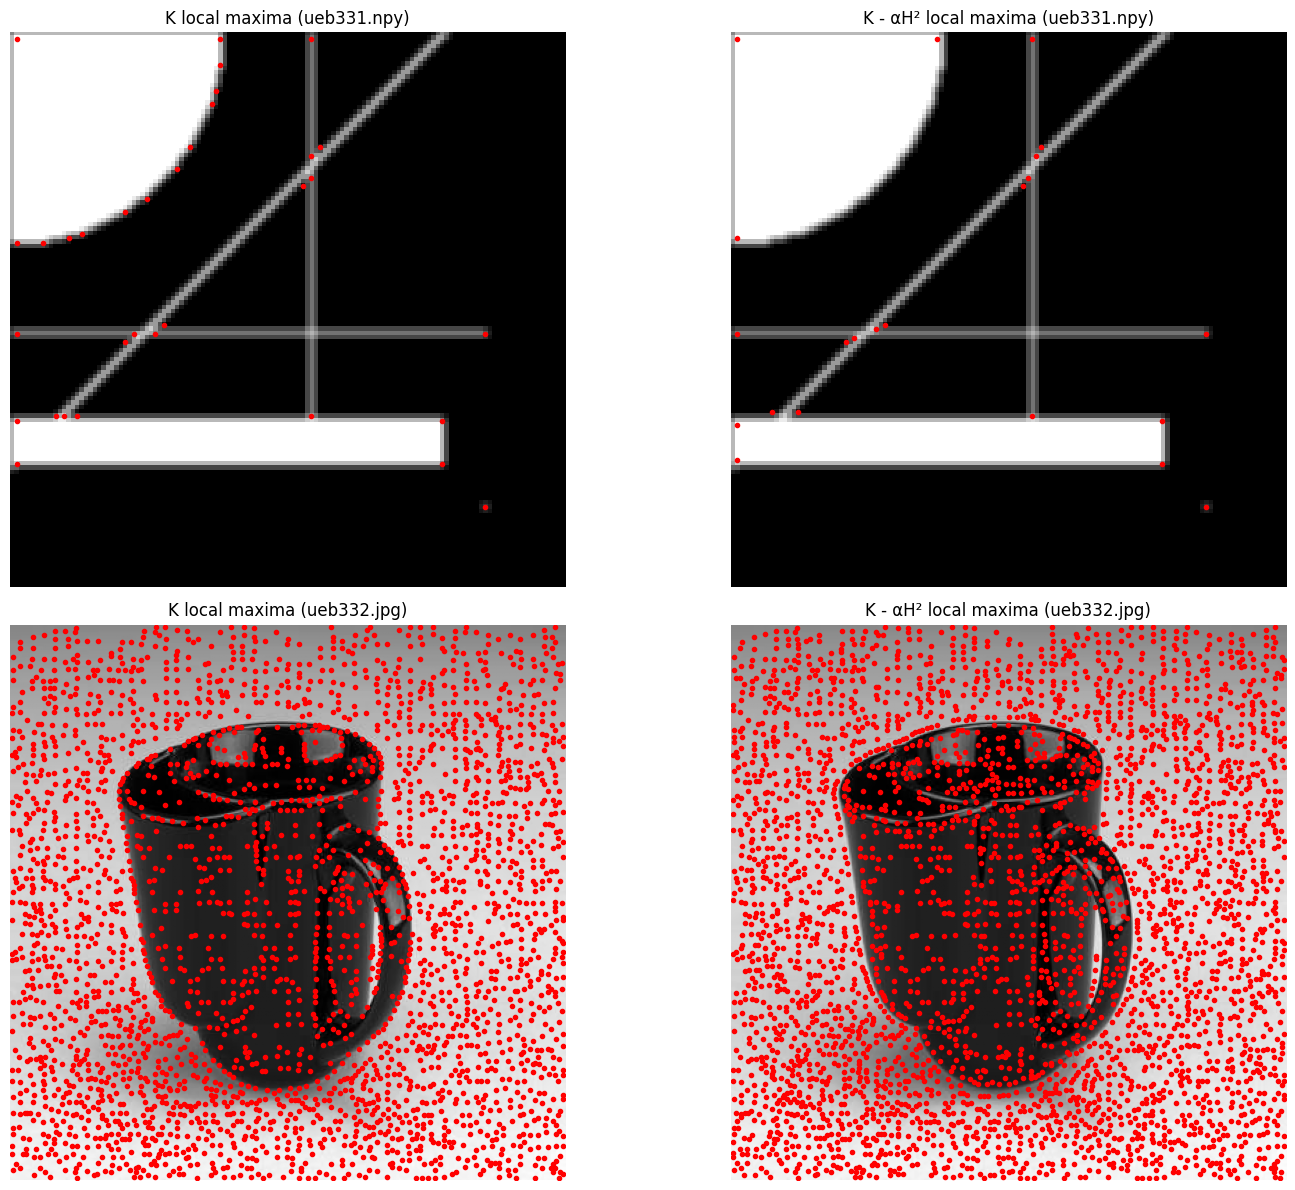

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.ndimage import maximum_filter as dilation

# Find local maxima above a threshold
def find_local_max(keypoints, thres=1e-6, k=3):
    kernel = np.ones((k, k))
    kernel[k//2, k//2] = 0
    local_max = keypoints > thres + dilation(keypoints, footprint=kernel)
    return local_max


# Plot keypoint marks on top of image
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)
    ax.plot(row, col, 'r.')

# Compute K and K - αH² based on structure tensor
def key_points_structure(image, alpha=0.04, sigma=0.1):
    image = image.astype(np.float32)

    # Step 0: Gaussian smoothing (σ = small)
    smoothed = gaussian_filter(image, sigma=sigma)

    # Step 1: Gradients
    Ix = cv2.Sobel(smoothed, cv2.CV_32F, 1, 0, ksize=3)
    Iy = cv2.Sobel(smoothed, cv2.CV_32F, 0, 1, ksize=3)

    # Step 2: Products of gradients
    Ix2 = Ix * Ix
    Iy2 = Iy * Iy
    Ixy = Ix * Iy

    # Step 3: Gaussian smoothing (σ = 1) on products
    Sx2 = gaussian_filter(Ix2, sigma=1)
    Sy2 = gaussian_filter(Iy2, sigma=1)
    Sxy = gaussian_filter(Ixy, sigma=1)

    # Step 4: Structure tensor invariants
    K = Sx2 * Sy2 - Sxy ** 2            # Determinant
    H = Sx2 + Sy2                       # Trace
    K_minus_H = K - alpha * (H ** 2)

    return K, K_minus_H

# === Main execution ===

# File paths
path_npy = '/content/cs4250/data/exercise_3/ueb331.npy'
path_img = '/content/cs4250/data/exercise_3/ueb332.jpg'

# Load test images
ueb331 = np.load(path_npy)
ueb332 = cv2.imread(path_img, cv2.IMREAD_GRAYSCALE)

# Parameters
alpha = 0.04
sigma = 0.1

# Extract keypoints (structure tensor invariants)
K_331, K_H_331 = key_points_structure(ueb331, alpha, sigma)
K_332, K_H_332 = key_points_structure(ueb332, alpha, sigma)

# Find local maxima
max_K_331 = find_local_max(K_331)
max_K_H_331 = find_local_max(K_H_331)
max_K_332 = find_local_max(K_332)
max_K_H_332 = find_local_max(K_H_332)

# Plot all keypoints over original images
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

ax[0, 0].imshow(ueb331, cmap='gray')
ax[0, 0].set_title("K local maxima (ueb331.npy)")
plot_marks(max_K_331, ax[0, 0])

ax[0, 1].imshow(ueb331, cmap='gray')
ax[0, 1].set_title("K - αH² local maxima (ueb331.npy)")
plot_marks(max_K_H_331, ax[0, 1])

ax[1, 0].imshow(ueb332, cmap='gray')
ax[1, 0].set_title("K local maxima (ueb332.jpg)")
plot_marks(max_K_332, ax[1, 0])

ax[1, 1].imshow(ueb332, cmap='gray')
ax[1, 1].set_title("K - αH² local maxima (ueb332.jpg)")
plot_marks(max_K_H_332, ax[1, 1])

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()
plt.show()
